https://geographicdata.science/book/notebooks/11_regression.html

In [2]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

# Data: San Diego AirBnB

In [3]:
db = geopandas.read_file('./data/airbnb/regression_db.geojson')

In [4]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [5]:
variable_names = [
    'accommodates',    # Number of people it accommodates
    'bathrooms',       # Number of bathrooms
    'bedrooms',        # Number of bedrooms
    'beds',            # Number of beds
    # Below are binary variables, 1 True, 0 False
    'rt_Private_room', # Room type: private room
    'rt_Shared_room',  # Room type: shared room
    'pg_Condominium',  # Property group: condo
    'pg_House',        # Property group: house
    'pg_Other',        # Property group: other
    'pg_Townhouse'     # Property group: townhouse
]

## Non-spatial regression

In [6]:
from pysal.model import spreg

In [7]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[['log_price']].values, 
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y='log_price', 
    # Independent variable name
    name_x=variable_names
)

In [8]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

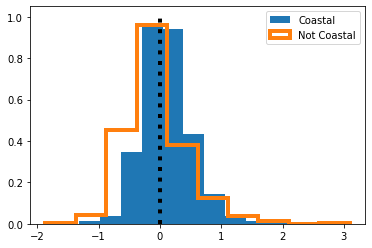

In [9]:
# 按區域分割，看看殘差是否有空間結構
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label='Coastal')
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal, 
    histtype='step',
    density=True, 
    linewidth=4, 
    label='Not Coastal'
)
# Add Line on 0
plt.vlines(0,0,1, linestyle=":", color='k', linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

In [11]:
# t檢定，是否有顯著差異
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]))

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


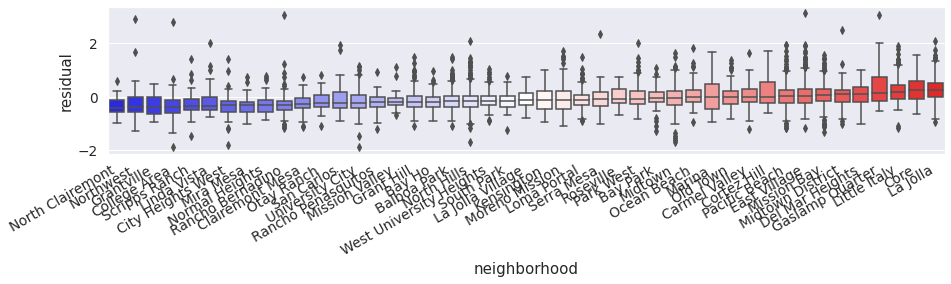

In [10]:
# Create column with residual values from m1
db['residual'] = m1.u
# Obtain the median value of residuals in each neighbourhood
medians = db.groupby(
    "neighborhood"
).residual.median().to_frame(
    'hood_residual'
)

# Increase fontsize
seaborn.set(font_scale = 1.25)
# Set up figure
f = plt.figure(figsize=(15,3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighbourhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    'neighborhood', 
    'residual', 
    ax = ax,
    data=db.merge(
        medians, 
        how='left',
        left_on='neighborhood',
        right_index=True
    ).sort_values(
        'hood_residual'), palette='bwr'
)
# Auto-format of the X labels
f.autofmt_xdate()
# Display
plt.show()

In [11]:
knn = weights.KNN.from_dataframe(db, k=1)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  warnings.warn(message)


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


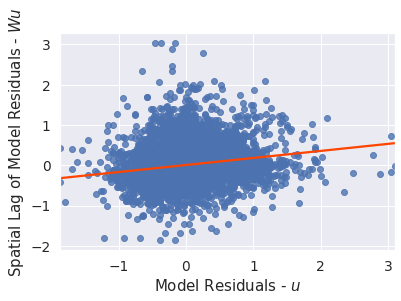

In [12]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


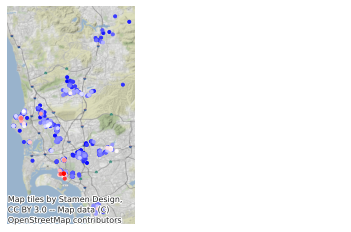

In [13]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardise weights
knn.transform = 'R'
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .001)
# Add `error_clusters` and `local_I` columns
ax = db.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.'
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off();

### 將與公園的距離加入模型

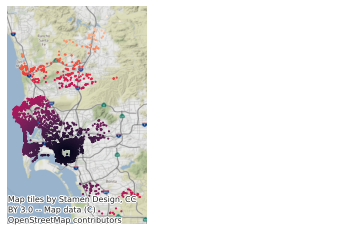

In [17]:
ax = db.plot('d2balboa', marker='.', s=5)
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off();

In [18]:
balboa_names = variable_names + ['d2balboa']

In [19]:
m2 = spreg.OLS(
    db[['log_price']].values, 
    db[balboa_names].values, 
    name_y = 'log_price', 
    name_x = balboa_names
)

In [22]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          12
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6098
R-squared           :      0.6685
Adjusted R-squared  :      0.6679
Sum squared residual:    1319.522                F-statistic           :   1117.9338
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3987.446
Sigma-square ML     :       0.216                Akaike info criterion :    7998.892
S.E of regression ML:      0.4647                Schwarz criterion     :    8079.504

-----------------------------------------------------------------------------

## Spatial Heterogeneity空間異質性

### Spatial Fixed Effects(FE)
$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

In [23]:
import statsmodels.formula.api as sm

In [24]:
# neighborhood - 1代表沒有截距項
f = 'log_price ~ ' + ' + '.join(variable_names) + ' + neighborhood - 1'
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


In [25]:
m3 = sm.ols(f, data=db).fit()

In [26]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if 'neighborhood[' in i]
# Create table
pandas.DataFrame(
    {
        'Coef.': m3.params[sfe_names],
        'Std. Error': m3.bse[sfe_names],
        'P-Value': m3.pvalues[sfe_names]
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


In [29]:
neighborhood_effects = m3.params.filter(like='neighborhood')
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

In [30]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    'neighborhood['
).str.strip(']')
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame('fixed_effect')
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


In [34]:
sd_path = './data/airbnb/neighbourhoods.geojson'
neighborhoods = geopandas.read_file(sd_path)

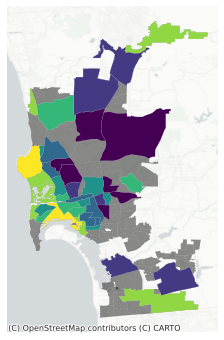

In [35]:
# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color='k', linewidth=0, alpha=0.5, figsize=(12,6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains AirBnb properties)
neighborhoods.merge(
    neighborhood_effects, 
    how='left',
    left_on='neighbourhood', 
    right_index=True
# Drop polygons without a SFE estimate
).dropna(
    subset=['fixed_effect']
# Plot quantile choropleth
).plot(
    'fixed_effect',     # Variable to display
    scheme='quantiles', # Choropleth scheme
    k=7,                # No. of classes in the choropleth
    linewidth=0.1,      # Polygon border width
    cmap='viridis',     # Color scheme
    ax=ax               # Axis to draw on
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=neighborhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

### Spatial Regimes(SR)
$$
\log{P_i} = \alpha_r + \sum_k \mathbf{X}_{ki}\beta_{k-r} + \epsilon_i
$$

In [15]:
# PySAL spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    db[['log_price']].values, 
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db['coastal'].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi='many',
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y='log_price', 
    # Independent variables names
    name_x=variable_names
)

In [16]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m5.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m5.t_stat]
    },
    index=m5.name_x
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if '1_' in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(
    lambda i: i.replace('1_', '')
)
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [['Coastal'], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if '0_' in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(
    lambda i: i.replace('0_', '')
)
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [['Non-coastal'], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

In [17]:
# 檢查兩個模型是否有顯著差異
m5.chow.joint

(328.8690214302136, 7.113548767599556e-64)

In [18]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=['Statistic', 'P-value']
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


## Spatial Dependence空間依賴性

### Exogenous effects: The SLX Model
$$
\log(P_i) = \alpha + \sum^{p}_{k=1}X_{ij}\beta_j + \sum^{p}_{k=1}\left(\sum^{N}_{j=1}w_{ij}x_{jk}\right)\gamma_k + \epsilon_i
$$

In [20]:
# Select only columns in `db` containing the keyword `pg_`
wx = db.filter(
    like='pg_'
# Compute the spatial lag of each of those variables
).apply(
    lambda y: weights.spatial_lag.lag_spatial(knn, y)
# Rename the spatial lag, adding w_ to the original name
).rename(
    columns=lambda c: 'w_'+c
# Remove the lag of the binary variable for apartments
).drop(
    'w_pg_Apartment', axis=1
)

In [23]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[['log_price']].values, 
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y='l_price', 
    # Independent variables names
    name_x=slx_exog.columns.tolist()
)

In [24]:
# Collect names of variables of interest
vars_of_interest = db[
    variable_names
].filter(
    like='pg_'
).join(
    wx
).columns
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m6.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m6.t_stat]
    },
    index=m6.name_x
# Subset for variables of itnerest only and round to
# four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


In [27]:
print(m6.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     l_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          15
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6095
R-squared           :      0.6800
Adjusted R-squared  :      0.6792
Sum squared residual:    1273.933                F-statistic           :    924.9423
Sigma-square        :       0.209                Prob(F-statistic)     :           0
S.E. of regression  :       0.457                Log likelihood        :   -3880.030
Sigma-square ML     :       0.208                Akaike info criterion :    7790.061
S.E of regression ML:      0.4566                Schwarz criterion     :    7890.826

-----------------------------------------------------------------------------

### Spatial Error
$$
\log{P_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 

In [34]:
# Fit spatial error model with `spreg` 
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    db[['log_price']].values, 
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn, 
    # Dependent variable name
    name_y='log_price', 
    # Independent variables names
    name_x=variable_names
)

In [29]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m7.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m7.z_stat]
    },
    index=m7.name_x
# Subset for lambda parameter and round to
# four decimals
).reindex(['lambda']).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.6449,0.0187,0.0


### Spatial Lag
$$
\log{P_i} = \alpha + \rho \log{P_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

In [36]:
# Fit spatial lag model with `spreg` 
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    db[['log_price']].values, 
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn, 
    # Dependent variable name
    name_y='log_price', 
    # Independent variables names
    name_x=variable_names
)

In [37]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m8.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m8.z_stat]
    },
    index=m8.name_z
# Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.7440,0.0727,0.0000
accommodates,0.0698,0.0048,0.0000
bathrooms,0.1627,0.0104,0.0000
bedrooms,0.1604,0.0105,0.0000
beds,-0.0365,0.0065,0.0000
rt_Private_room,-0.4981,0.0151,0.0000
rt_Shared_room,-1.1157,0.0366,0.0000
pg_Condominium,0.1073,0.0209,0.0000
pg_House,-0.0004,0.0137,0.9766
pg_Other,0.1208,0.0215,0.0000
